# Exploring ESA WorldCover with Wherobots 🚀

This notebook serves as a **good starting point** for working with **ESA WorldCover data in Wherobots**.

We will:
- Load **Cloud Optimized GeoTIFF (COG) rasters** from **ESA WorldCover**, hosted on **AWS S3**.
- Use **Wherobots** to **efficiently explore** raster metadata and perform **spatial filtering**.
- Visualize **tile distributions** and **land cover classifications** over Idaho.

## Why Use Wherobots for ESA WorldCover?
Processing **large-scale raster data** is often **slow and memory-intensive**.  
With **Wherobots**, we leverage:

✅ **Lazy Loading** → Raster data is **not pulled into memory** until a query requests pixel values.  
✅ **Distributed Raster Access** → Allows **fast indexing & querying** without moving large files.  
✅ **Optimized COG Reads** → Reads only the **necessary raster tiles**, improving efficiency.  
✅ **Seamless Integration of Raster & Vector Data** → Wherobots allows users to work with **both raster and vector datasets** in the same environment, making **complex spatial joins intuitive and efficient**.  

With Wherobots, you can **easily overlay ESA WorldCover land cover rasters** with:
- **Vector boundaries (e.g., administrative regions, watersheds)** 🌍
- **Point datasets (e.g., GPS locations, sensor data)** 📍
- **Line features (e.g., roads, rivers)** 🚗🌊

This makes Wherobots **ideal for exploring, joining, and analyzing spatial data seamlessly** before deeper processing.

## What is ESA WorldCover? 🌍

The **[ESA WorldCover](https://aws.amazon.com/marketplace/pp/prodview-7oorylcamixxc#overview)** dataset provides **high-resolution global land cover maps**  
developed using **Sentinel-1 & Sentinel-2 satellite imagery**.

### 🌱 How is This Useful?
This dataset allows us to **analyze land cover changes** for:
- **Urban Expansion** - Identifying areas undergoing rapid development.  
- **Deforestation Monitoring** - Detecting changes in forest cover over time.  
- **Water Body Analysis** - Observing changes in lakes, rivers, and coastal areas.  
- **Agriculture & Land Use** - Mapping croplands and classifying vegetation.  

### 📌 Dataset Overview
- **Resolution**: 10 meters 🌍
- **Years Available**: 2020, 2021 📅
- **Format**: **Cloud Optimized GeoTIFF (COG)**
- **Hosted on AWS**: `s3://esa-worldcover/v200/2021/map/`
- **Projection**: EPSG:4326 (WGS84)

With **Wherobots**, we can **quickly access and filter** this dataset and performing **detailed analyses**.

## Set up your Sedona context

This is the machine that makes everything run. It will connect you to Wherobots Cloud compute environment to make sure everything runs 🏎️ **fast and efficiently**.

### 🧰 **The configuration**
This first step allows you to set up the configuration for your compute environment, like setup up access credentials for an s3 bucket. There are other things you can add into this if you want but this is the base to get you up and running.

```python
config = SedonaContext.builder().getOrCreate()
```

📓 Here is some more [information from our documentation](https://docs.wherobots.com/latest/develop/notebook-management/notebook-instance-management/) on setting up your compute environment

In [1]:
from sedona.spark import *

try:
    sedona
except NameError:
    config = SedonaContext.builder() \
    .config("fs.s3a.bucket.esa-worldcover.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.bucket.esa-worldcover.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .getOrCreate()
    sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## The Raster Data Source in Wherobots 🚀

Wherobots provides a **powerful raster data source** that allows users to:

✅ **Read Cloud Optimized GeoTIFFs (COGs) efficiently in a distributed manner.**  
✅ **Dynamically tile large rasters** for parallel processing across multiple nodes.  
✅ **Perform spatial filtering before pixel processing**, improving performance.  

### **Why Retiling Matters**
Retiling helps:
- Optimize **query performance** by breaking large images into manageable chunks.
- Speed up **spatial joins and filtering**, as each tile is processed independently.
- Reduce **memory overhead**, ensuring raster operations are efficient.

If you prefer to **work with the original raster structure**, you can disable retiling using:
`option("retile", "false")`

In [ ]:
df2 = sedona.read.format("raster").option("retile", "true").load("s3://esa-worldcover/v200/2021/map/*.tif*")

In [15]:
df2.printSchema()

root
 |-- rast: raster (nullable = true)
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)



In [16]:
df2.count()

3435696

## Understanding Raster Metadata 🏗️

Before processing rasters, it is useful to **inspect metadata**:
- **Geometry** (`RS_Envelope`) → The spatial extent of each raster tile.
- **Area** (`ST_Area`) → The real-world area covered by each tile.
- **Metadata** (`RS_Metadata`) → All metadata of the raster including tile size, coordinate reference system, etc. [Here's](https://docs.wherobots.com/latest/api/wherobots-compute/sql/Raster-operators/?h=rs_metadata#rs_metadata) more information on the metadata for rasters.

These allow us to **spatially filter** and **query raster data** efficiently.

In [3]:
from pyspark.sql.functions import col, expr

esa_df = df2.withColumn("geometry", expr("RS_Envelope(rast)"))\
            .withColumn("area", expr("ST_Area(geometry)"))\
            .withColumn("metadata", expr("RS_Metadata(rast)"))

In [4]:
esa_df.show()

+--------------------+---+---+--------------------+--------------------+--------------------+
|                rast|  x|  y|            geometry|                area|            metadata|
+--------------------+---+---+--------------------+--------------------+--------------------+
|OutDbGridCoverage...| 26| 11|POLYGON ((38.2186...|0.007281777777778...|{38.2186666666666...|
|OutDbGridCoverage...| 29| 33|POLYGON ((38.4746...|0.007281777777778...|{38.4746666666666...|
|OutDbGridCoverage...| 11|  5|POLYGON ((36.9386...|0.007281777777778...|{36.9386666666666...|
|OutDbGridCoverage...| 16| 31|POLYGON ((34.3653...|0.007281777777778...|{34.3653333333333...|
|OutDbGridCoverage...| 29|  9|POLYGON ((35.4746...|0.007281777777778...|{35.4746666666666...|
|OutDbGridCoverage...| 12| 17|POLYGON ((64.024 ...|0.007281777777777...|{64.024, 34.54933...|
|OutDbGridCoverage...|  8|  8|POLYGON ((63.6826...|0.007281777777778599|{63.6826666666666...|
|OutDbGridCoverage...| 27| 10|POLYGON ((116.304...|0.0072817

## Exploring Idaho’s Land Cover Tiles 🏞️

Let’s explore the **ESA WorldCover land cover tiles in Idaho** and see how they look.  
Using the **`ST_Intersects`** predicate, we can efficiently **filter** the raster tiles  
that intersect with the **Idaho state boundary**.

Since Wherobots **lazy loads raster data**, this operation only filters metadata  
without actually loading raster pixels—ensuring optimal performance.

In [6]:
idaho_wkt = 'POLYGON ((-117.025719 42.008404, -111.038632 42.008404, -111.049617 44.457228, -111.379182 44.738848, -111.489037 44.652943, -111.423124 44.535593, -111.653819 44.574736, -111.818601 44.519928, -112.279991 44.551253, -112.785323 44.480748, -112.829265 44.34734, -113.005033 44.527761, -113.103902 44.738848, -113.257699 44.816834, -113.411496 44.855787, -113.496919 44.945341, -113.450231 44.951173, -113.433753 45.007515, -113.455724 45.061861, -113.521637 45.085137, -113.502412 45.116156, -113.565578 45.120033, -113.562832 45.158781, -113.680926 45.274866, -113.7386 45.325096, -113.733107 45.390715, -113.777049 45.41, -113.760571 45.481298, -113.763317 45.517875, -113.82923 45.519799, -113.790781 45.587114, -113.815498 45.615938, -113.897889 45.619781, -113.881411 45.650508, -113.936338 45.700405, -113.991266 45.709995, -114.032461 45.683138, -114.013237 45.650508, -114.059925 45.635147, -114.128584 45.58327, -114.153302 45.556352, -114.252171 45.550582, -114.337308 45.462037, -114.367519 45.498627, -114.422446 45.514026, -114.455402 45.565967, -114.551525 45.565967, -114.529554 45.60441, -114.557018 45.635147, -114.493852 45.665866, -114.491105 45.708077, -114.559764 45.77325, -114.499344 45.836434, -114.414207 45.847914, -114.38125 45.886165, -114.427939 45.935851, -114.397729 45.960677, -114.427939 45.995034, -114.474627 46.000758, -114.466388 46.027462, -114.502091 46.036996, -114.452656 46.096071, -114.521315 46.145569, -114.438924 46.166497, -114.441671 46.236833, -114.469134 46.274815, -114.425192 46.278611, -114.4197 46.310873, -114.405968 46.356387, -114.416953 46.381024, -114.367519 46.441622, -114.400475 46.490809, -114.342801 46.511606, -114.323577 46.577723, -114.32083 46.658843, -114.359279 46.675806, -114.422446 46.664498, -114.458149 46.655072, -114.477373 46.634331, -114.546033 46.655072, -114.603706 46.639988, -114.609199 46.660728, -114.617438 46.709716, -114.647648 46.737959, -114.699829 46.749251, -114.724547 46.719132, -114.773981 46.715366, -114.75201 46.75866, -114.78222 46.786877, -114.861865 46.818838, -114.927778 46.860171, -114.914046 46.920236, -114.996437 46.980233, -115.136502 47.100025, -115.257342 47.182226, -115.320509 47.260573, -115.52374 47.301565, -115.540219 47.357412, -115.611624 47.390892, -115.746196 47.42621, -115.611624 47.481925, -115.691269 47.533873, -115.685776 47.596884, -115.71324 47.702349, -115.787392 47.757772, -115.856051 47.83342, -116.048297 47.982549, -116.045551 49.001825, -117.028751 49.000023, -117.035969 46.445348, -116.9371 46.172143, -117.003013 46.07315, -116.47571 45.606271, -117.266664 44.441542, -117.233708 44.292318, -116.948085 44.166362, -117.035969 43.834444, -117.025719 42.008404))'

In [7]:
# Filter Idaho land cover tiles
idaho_df = esa_df.filter(f"ST_Intersects(geometry, ST_GeomFromWKT('{idaho_wkt}'))")

# Show count of tiles in Idaho
idaho_df.count()

3734

## Lets visualize the spatial extent of these tiles using SedonaKepler
More docs for SedonaKepler [here](https://docs.wherobots.com/latest/api/wherobots-compute/sql/Visualization_SedonaKepler/?h=sedonakepler).

In [ ]:
SedonaKepler.create_map(idaho_df.select("geometry"))

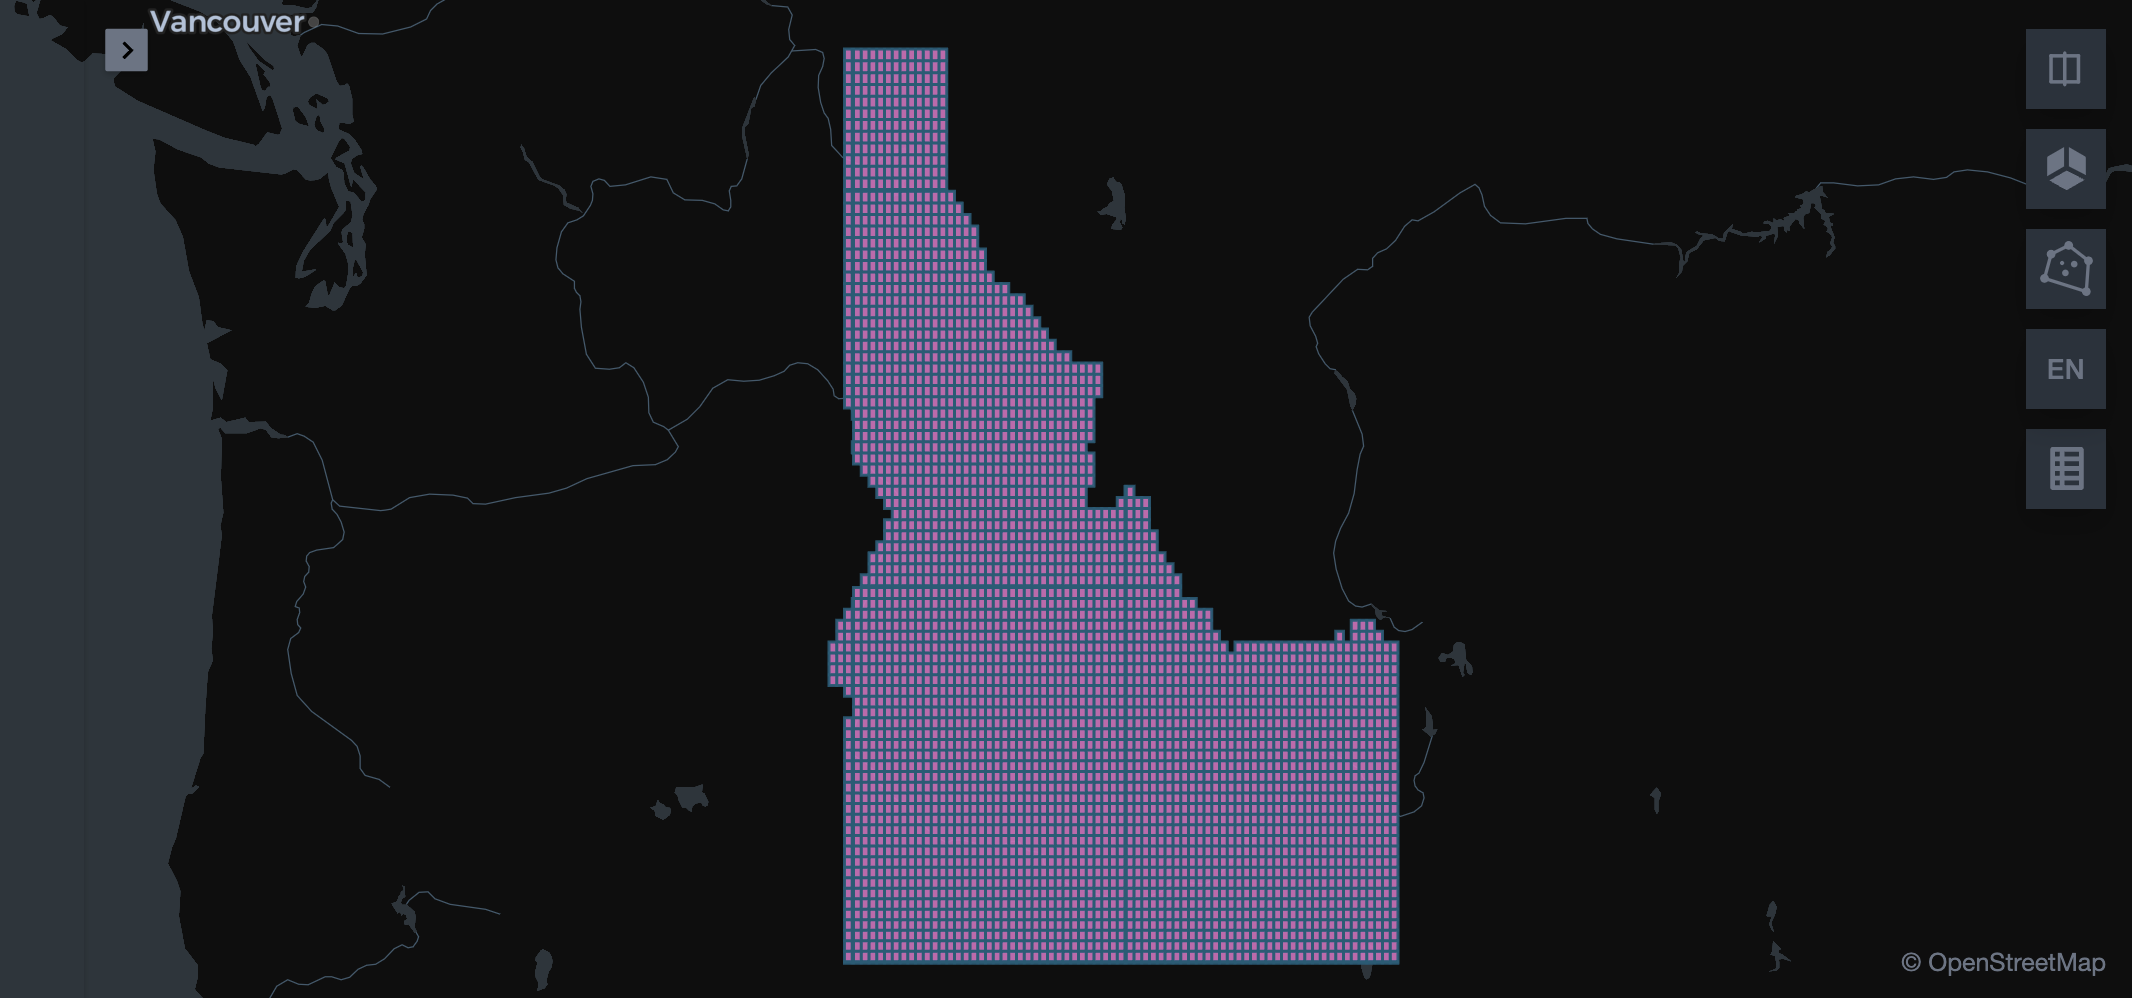

## Raster Data Visualization: Land Cover Classification 🌿🏙️

Now, let's take a look at those Land Cover Classifications! 😍
- **`RS_AsImage(rast, 300)`** → Converts raster tiles to images.
- **`SedonaUtils.display_image()`** → Displays raster images inline.

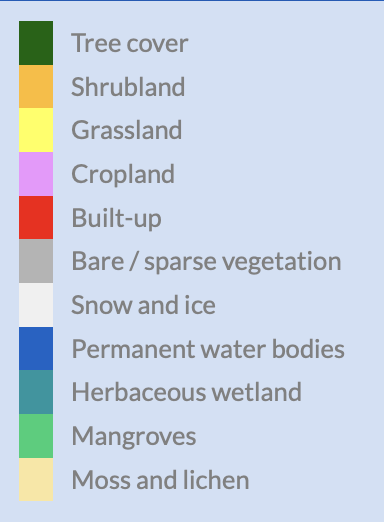

In [28]:
htmlDf = idaho_df.selectExpr("RS_AsImage(rast, 300)").limit(5)

,"rs_asimage(rast, 300)"
0,
1,
2,
3,
4,

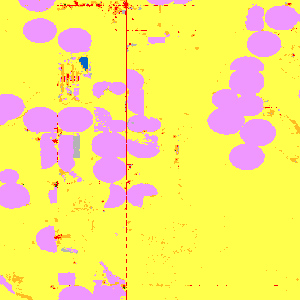
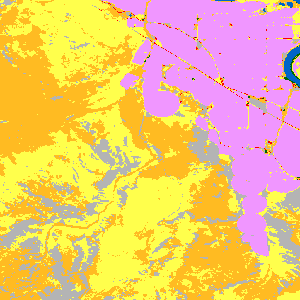
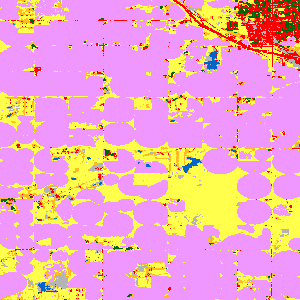
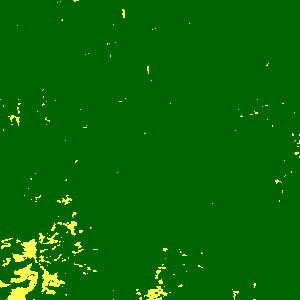
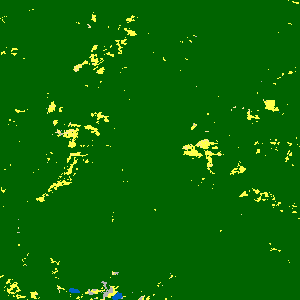

In [29]:
SedonaUtils.display_image(htmlDf)